##### **Background:**

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.



MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.



##### **Data Description:**

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

##### **Goal(s):**

Predict if the page is being flipped using a single image.

##### **Success Metrics:**

Evaluate model performance based on F1 score, the higher the better.

##### **Bonus(es):**

Predict if a given sequence of images contains an action of flipping.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


##### **Load Data and Augment Training Data**

This is a binary image classification problem, Convolutional Neural Networks (CNN) are very good at this task and therefore I will create a simple one to see how it performs.

To start off I'll load in the dataset as different datasets for training, validation, and testing.

In [2]:
#paths for images
train_dir = "images/training"
test_dir = "images/testing"

#load the training dataset
train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
    label_mode='binary'
)

#load the validation dataset
validation_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
    label_mode='binary'
)

#load the testing dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='binary'
)

class_names = train_dataset.class_names
print("Class names:", class_names)

#prefetching and caching for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Found 2392 files belonging to 2 classes.
Using 478 files for validation.
Found 597 files belonging to 2 classes.
Class names: ['flipped', 'notflipped']


##### **Model Creation and Design**

I'll then design a simple CNN to take a 256x256 image with 3 color channels as input and a sigmoid activation output layer to produce a value between 0 and 1

In [3]:
#create a simple CNN model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)), #rescale the pixel values to [0, 1]
    layers.Conv2D(32, (3, 3), activation='relu'), #32 filters, 3x3 kernel
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  #sigmoid for binary classification
])

print(model.summary())

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

#evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       7

In [4]:
#classification report
y_pred = model.predict(test_dataset)
y_pred = np.round(y_pred)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

#confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cm)

19/19 [==============================] - 0s 8ms/step
Classification report:
              precision    recall  f1-score   support

     flipped       0.99      0.99      0.99       290
  notflipped       0.99      0.99      0.99       307

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597

Confusion matrix:
[[287   3]
 [  2 305]]


True label: 0, Prediction score: 0.9999442100524902, Predicted label: 1


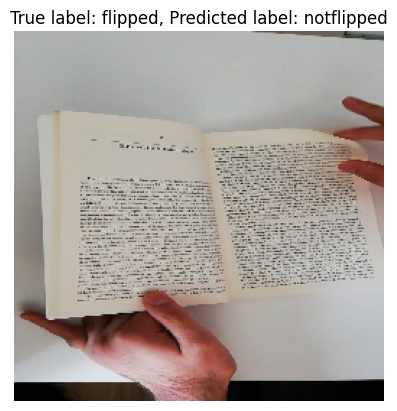

True label: 1, Prediction score: 0.0478346161544323, Predicted label: 0


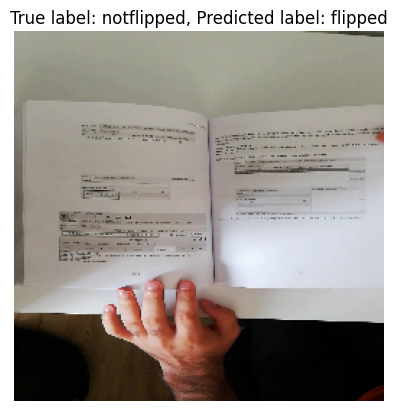

True label: 0, Prediction score: 0.9584909081459045, Predicted label: 1


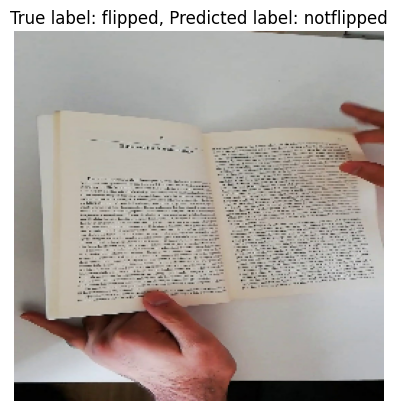

True label: 0, Prediction score: 0.7707098126411438, Predicted label: 1


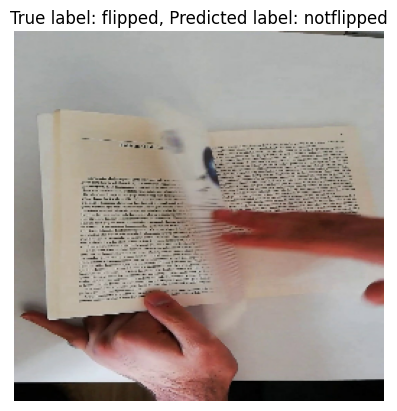

True label: 1, Prediction score: 0.48038986325263977, Predicted label: 0


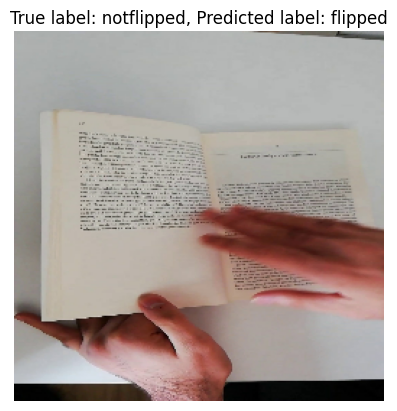

In [5]:
#function to display an image with its true and predicted labels
def display_image_with_prediction(image, true_label, predicted_label):
    plt.imshow(image.astype("uint8"))
    plt.title(f"True label: {'notflipped' if true_label == 1 else 'flipped'}, Predicted label: {'notflipped' if predicted_label == 1 else 'flipped'}")
    plt.axis('off')
    plt.show()


#iterate over the images from the test dataset and display only the misclassified ones
for images, labels in test_dataset:
    for i in range(len(images)):
        image = images[i].numpy()
        true_label = labels[i].numpy()[0].astype(int)

        image_processed = np.expand_dims(image, axis=0)

        #usee the model to predict the label for the image
        prediction_score = model.predict(image_processed, verbose=0)
        predicted_label = (prediction_score > 0.5).astype(int).flatten()[0]

        #display the image only if it was misclassified
        if true_label != predicted_label:
            print(f"True label: {true_label}, Prediction score: {prediction_score.flatten()[0]}, Predicted label: {predicted_label}")
            display_image_with_prediction(image, true_label, predicted_label)
            

##### **Conclusion**

This dataset is very small in the grand scheme of image classification, and therefore is likely overfitting to this specific dataset. The model would likely not generalize well with other images of books being flipped or not, and would likely fail in edge case scenarios as shown in some of the images above. However, for the purposes of this excersize, this CNN almost perfectly predicts whether a page is being flipped or not and achieves an almost perfect f1 score of .98.

To further improve this model, the most important factor is dataset size. After that, there are many other techniques such as data augmentation to increase the size of the dataset, as well as add in variations of images to help the model generalize better. Otherwise, general CNN hyperparameter tuning and model redesigns would help this model reach better potential.